<a href="https://colab.research.google.com/github/peter000815/BA0815/blob/master/algorithm_comparsion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Get the information of Heimingway's living place

In [ ]:
from geopy.geocoders import Nominatim

In [ ]:
location_list = ["Oak Park, Illinois, USA", "Horton Bay, Michigan, USA", 
                 "Paris, France", "Pamplona, Spain", "Madrid, Spain", 
                 "Havana, Cuba", "Key West, Florida, USA", "Ketchum, Idaho"]

In [ ]:
import pandas as pd
locator = Nominatim(user_agent="myGeocoder")
df = pd.DataFrame(location_list, columns = ['location'])
df["latitude"] = df.location.apply(lambda x: locator.geocode(x).latitude)
df["longitude"] = df.location.apply(lambda x: locator.geocode(x).longitude)
df

,location,latitude,longitude
0,"Oak Park, Illinois, USA",41.887814,-87.788762
1,"Horton Bay, Michigan, USA",45.284453,-85.078946
2,"Paris, France",48.856697,2.351462
3,"Pamplona, Spain",42.818454,-1.644256
4,"Madrid, Spain",40.416705,-3.703582
5,"Havana, Cuba",23.135305,-82.358963
6,"Key West, Florida, USA",24.562557,-81.772437
7,"Ketchum, Idaho",43.680741,-114.363662


In [ ]:
! pip install geopandas

In [ ]:
import geopandas
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))

In [ ]:
import matplotlib.pyplot as plt
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(20, 15))
gdf.plot(ax=ax, color='red')
plt.show()

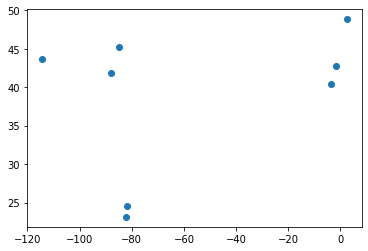

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(df["longitude"], df["latitude"])

In [ ]:
array = np.array([(-87.7887615,  41.8878145),(-85.0789462,  45.2844529),(2.3514616, 48.8566969),(-1.6442556, 42.8184538),(-3.7035825, 40.4167047),(-82.3589631,  23.135305),(-81.7724368,  24.5625566),(-114.363662,   43.680741)])

Dynamic Programming

In [ ]:
import time
import numpy as np
np.random.seed(2)

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def DP_TSP(distances_array):
    n = len(distances_array)
    all_points_set = set(range(n))
    memo = {(tuple([i]), i): tuple([0, None]) for i in range(n)}
    queue = [(tuple([i]), i) for i in range(n)]

    while queue:
        prev_visited, prev_last_point = queue.pop(0)
        prev_dist, _ = memo[(prev_visited, prev_last_point)]

        to_visit = all_points_set.difference(set(prev_visited))
        for new_last_point in to_visit:
            new_visited = tuple(sorted(list(prev_visited) + [new_last_point]))
            new_dist = prev_dist + distances_array[prev_last_point][new_last_point]

            if (new_visited, new_last_point) not in memo:
                memo[(new_visited, new_last_point)] = (new_dist, prev_last_point)
                queue += [(new_visited, new_last_point)]
            else:
                if new_dist < memo[(new_visited, new_last_point)][0]:
                    memo[(new_visited, new_last_point)] = (new_dist, prev_last_point)

    optimal_path, optimal_cost = retrace_optimal_path(memo, n)

    return optimal_path, optimal_cost


In [ ]:
def retrace_optimal_path(memo: dict, n: int) -> [[int], float]:
    points_to_retrace = tuple(range(n))

    full_path_memo = dict((k, v) for k, v in memo.items() if k[0] == points_to_retrace)
    path_key = min(full_path_memo.keys(), key=lambda x: full_path_memo[x][0])

    last_point = path_key[1]
    optimal_cost, next_to_last_point = memo[path_key]

    optimal_path = [last_point]
    points_to_retrace = tuple(sorted(set(points_to_retrace).difference({last_point})))

    while next_to_last_point is not None:
        last_point = next_to_last_point
        path_key = (points_to_retrace, last_point)
        _, next_to_last_point = memo[path_key]

        optimal_path = [last_point] + optimal_path
        points_to_retrace = tuple(sorted(set(points_to_retrace).difference({last_point})))

    return optimal_path, optimal_cost

In [ ]:
def plot_route(X, optimal_path):
    for p1, p2 in zip(optimal_path[:-1], optimal_path[1:]):
        plt.plot([X[p1, 0], X[p2, 0]], [X[p1, 1], X[p2, 1]]);

In [ ]:
def generate_input(ar_name):
    X = ar_name
    distances_array = np.array([[np.linalg.norm(X[i] - X[j])
                                for i in range(ar_name.shape[0])]
                              for j in range(ar_name.shape[0])])
    return X, distances_array

In [ ]:
ar_name = array
X, distances_array = generate_input(ar_name)

t = time.time()
optimal_path, optimal_cost = DP_TSP(distances_array)
runtime = round(time.time() - t, 3)

print(f"Found optimal path in {runtime} seconds.") 
print(f"Optimal cost: {round(optimal_cost, 3)}, optimal path: {optimal_path}")

Found optimal path in 0.013 seconds.
Optimal cost: 144.443, optimal path: [2, 3, 4, 5, 6, 1, 0, 7]


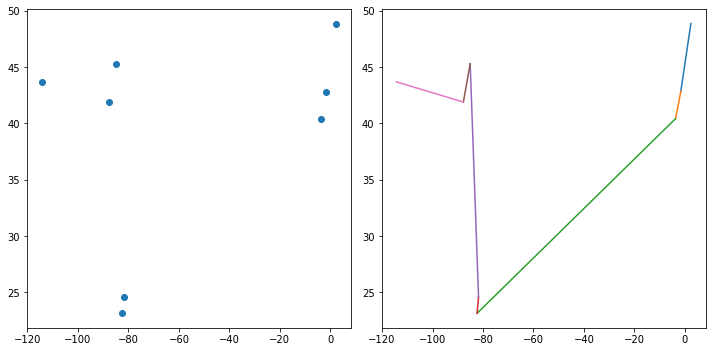

In [ ]:
plt.figure(figsize=(10, 5));

plt.subplot(1, 2, 1);
plt.scatter(X[:, 0], X[:, 1]);

plt.subplot(1, 2, 2);
plot_route(X, optimal_path)

plt.tight_layout();

Heuristic Solution

In [ ]:
import math
import random
random.seed(42)

class YATS:
    def __init__(self, n_iter: int = 100):
        self.n_iter = n_iter
        
    def get_best_route(self, points: np.array, distances_array: np.array) -> [[int], float]:
        optimal_path = self._get_angular_route(points)
        optimal_path = self._optimize_route(distances_array, optimal_path)
        optimal_cost = self._get_route_len(distances_array, optimal_path)
        return optimal_path, optimal_cost
    
    def _get_angular_route(self, points: np.array) -> [int]:
        center = np.mean(points, axis=0)
        route_idxs = sorted(list(range(len(points))),
                            key=lambda i:
                            self._get_angle_from_reference_point_in_deg(center, points[i, :]),
                            reverse=True)
        return route_idxs

    def _get_angle_from_reference_point_in_deg(self, reference_point: np.array, other_point: np.array) -> float:
        x, y = other_point - reference_point
        angle_from_reference_in_deg = math.degrees(math.atan2(y, x))
        return angle_from_reference_in_deg
    
    def _optimize_route(self, distances_array: np.array, route_idxs: [int]) -> [int]:
        prev_cost = self._get_route_len(distances_array, route_idxs)

        all_idxs = list(range(len(route_idxs)))
        for _ in range(self.n_iter):
            i1, i2 = random.sample(all_idxs, 2)
            route_idxs[i2], route_idxs[i1] = route_idxs[i1], route_idxs[i2]
            new_cost = self._get_route_len(distances_array, route_idxs)
            if new_cost < prev_cost:
                prev_cost = new_cost
            else:
                route_idxs[i2], route_idxs[i1] = route_idxs[i1], route_idxs[i2]
        return route_idxs

    def _get_route_len(self, distances_array: np.array, route_idxs: [int]):
        route_len = sum([distances_array[i1][i2]
                         for i1, i2 in zip(route_idxs[:-1], route_idxs[1:])])
        return route_len

In [ ]:
yats = YATS()
t_yats = time.time()
optimal_path_yats, optimal_cost_yats = yats.get_best_route(X, distances_array)
runtime_yats = round(time.time() - t_yats, 3)

print(f"Found heuristic path in {runtime_yats} seconds.") 
print(f"Heuristic cost: {round(optimal_cost_yats, 3)}, heuristic optimal path: {optimal_path_yats}")

Found heuristic path in 0.002 seconds.
Heuristic cost: 210.094, heuristic optimal path: [7, 0, 1, 2, 3, 4, 6, 5]


Greedy Algorithm

In [ ]:
import numpy as np

def algorithm(cities):
	best_order = []
	best_length = float('inf')

	for i_start, start in enumerate(cities):
		order = [i_start]
		length = 0
    ### complete the get_closest function
		i_next, next, dist =   get_closest(start, cities, order)
		length += dist
		order.append(i_next)

		while len(order) < cities.shape[0]:
			i_next, next, dist = get_closest(next, cities, order)
			length += dist
			order.append(i_next)

		#print(order)

		if length < best_length:
			best_length = length
			best_order = order
	return best_order, best_length 

def get_closest(city, cities, visited):
	best_distance = float('inf')

	for i, c in enumerate(cities):

		if i not in visited:
			distance = dist_squared(city, c)**0.5

			if distance < best_distance:
				closest_city = c
				i_closest_city = i
				best_distance = distance

	return i_closest_city, closest_city, best_distance


def dist_squared(c1, c2):
	t1 = c2[0] - c1[0]
	t2 = c2[1] - c1[1]

	return t1**2 + t2**2


In [ ]:
GA_time = time.time()
optimal_path_GA, optimal_cost_GA = algorithm(array)
runtime_GA = round(time.time() - GA_time, 3)

print(f"Found GA path in {runtime_GA} seconds.") 
print(f"GA cost: {round(optimal_cost_GA, 3)}, GA optimal path: {optimal_path_GA}")

Found GA path in 0.001 seconds.
GA cost: 144.443, GA optimal path: [7, 0, 1, 6, 5, 4, 3, 2]


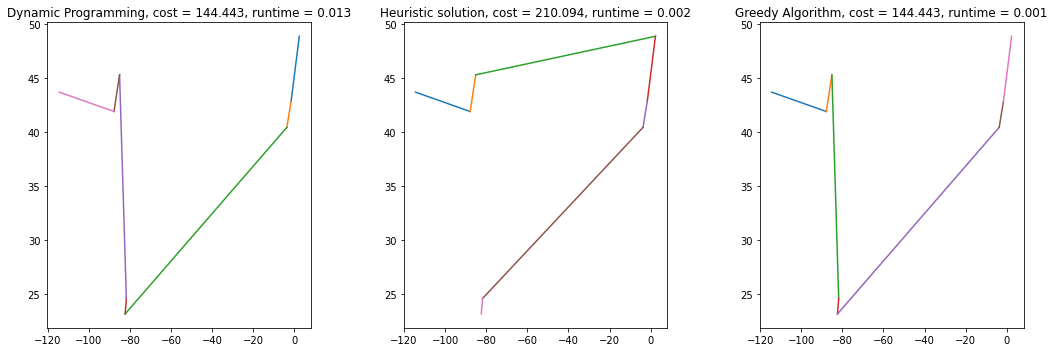

In [ ]:
plt.figure(figsize=(15, 5));

plt.subplot(1, 3, 1);
plot_route(X, optimal_path)
plt.title(f"Dynamic Programming, cost = {round(optimal_cost, 3)}, runtime = {runtime}")

plt.subplot(1, 3, 2);
plot_route(X, optimal_path_yats)
plt.title(f"Heuristic solution, cost = {round(optimal_cost_yats, 3)}, runtime = {runtime_yats}")

plt.subplot(1,3,3)
plot_route(X , optimal_path_GA)
plt.title(f"Greedy Algorithm, cost = {round(optimal_cost_GA, 3)}, runtime = {runtime_GA}")

plt.tight_layout();

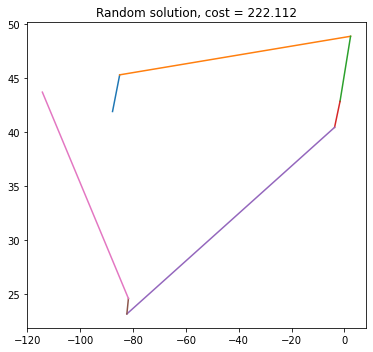

In [ ]:
plt.figure(figsize=(15, 5));
plt.subplot(1, 3, 1);
random_path = list(range(len(X)))
random_cost = yats._get_route_len(distances_array, random_path)
plot_route(X, random_path)
plt.title(f"Random solution, cost = {round(random_cost, 3)}")

plt.tight_layout();